In [1]:
import sys
sys.path.append("/home/twhit/smc_object_detection/")
from smc.sampler import SMCsampler
from smc.prior import StarPrior
from smc.images import ImageModel
from smc.kernel import MetropolisHastings
from smc.aggregate import Aggregate

import torch
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import numpy as np
import matplotlib.pyplot as plt

### Load in images

In [2]:
images = torch.load('../data/images.pt').to(device)
true_counts = torch.load('../data/true_counts.pt').to(device)
true_locs = torch.load('../data/true_locs.pt').to(device)
true_fluxes = torch.load('../data/true_fluxes.pt').to(device)

num_counts = true_counts.max().item() + 1  # |{0,1,2,...,max_count}|

In [3]:
image_dim = images.shape[1]
image_index = 69

grid_interval = image_dim // 4
outer_min = 0 - 0.5
outer_max = image_dim - 0.5
pad = 2

cmap = 'gray'
linewidth = 2
pad_color1 = 'orangered'
pad_color2 = 'mediumseagreen'

In [4]:
# for image_index in range(60,70):
#     image = images[image_index]
#     image_height = image.shape[0]
#     image_width = image.shape[1]

#     c = true_counts[image_index]
#     l = true_locs[image_index]
    
#     fig, ax = plt.subplots(1, 1, figsize = (2,2))
#     img = ax.imshow(image.cpu(), cmap = cmap)
#     _ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
#     _ = ax.set_xticks([])
#     _ = ax.set_yticks([])
#     _ = ax.scatter(l.cpu()[:c.cpu().item(), 1] - 0.5,
#                l.cpu()[:c.cpu().item(), 0] - 0.5,
#                color = 'gold', edgecolors = 'black', marker = '*', s = 200)

In [5]:
image = images[image_index]
image_height = image.shape[0]
image_width = image.shape[1]

true_counts = true_counts[image_index]
true_locs = true_locs[image_index]
true_fluxes = true_fluxes[image_index]

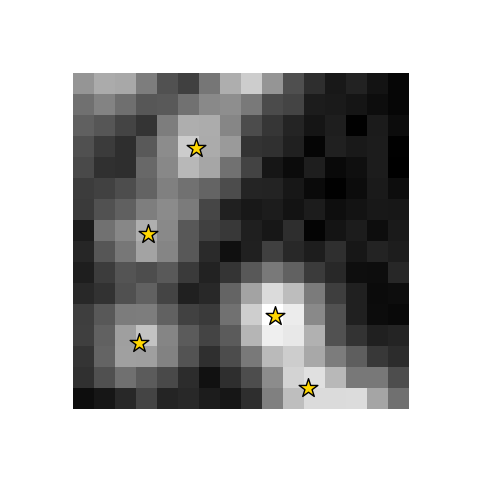

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (6,6))
img = ax.imshow(image.cpu(), cmap = cmap)
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

_ = ax.scatter(true_locs.cpu()[:true_counts.cpu().item(), 1] - 0.5,
               true_locs.cpu()[:true_counts.cpu().item(), 0] - 0.5,
               color = 'gold', edgecolors = 'black', marker = '*', s = 200)
_ = ax.vlines(x = [outer_min - pad, outer_max + pad],
              ymin = outer_min - pad, ymax = outer_max + pad,
              color = 'white', linewidth = linewidth)
_ = ax.hlines(y = [outer_min - pad, outer_max + pad],
              xmin = outer_min - pad, xmax = outer_max + pad,
              color = 'white', linewidth = linewidth)

### Run sampler

In [7]:
prior = StarPrior(max_objects = 10,
                  image_height = image_height,
                  image_width = image_width,
                  flux_mean = 80000,
                  flux_stdev = 15000,
                  pad = 2)

imagemodel = ImageModel(image_height = image_height,
                        image_width = image_width,
                        psf_stdev = 1.5,
                        background = 100000)

mh = MetropolisHastings(num_iters = 75,
                        locs_stdev = 0.1,
                        features_stdev = 1000,
                        features_min = 50000,
                        features_max = 110000)

In [8]:
torch.manual_seed(0)

print(f"true count = {true_counts}")
print(f"true total flux = {true_fluxes.sum()}\n")

sampler = SMCsampler(image = image,
                    tile_dim = image_height,
                    Prior = prior,
                    ImageModel = imagemodel,
                    MutationKernel = mh,
                    num_catalogs_per_count = 2000,
                    max_smc_iters = 200)

sampler.run(print_progress = True)

true count = 5
true total flux = 387310.0625

Starting the tile samplers...
iteration 5, temperature = 0.008851579390466213
iteration 10, temperature = 0.03939235582947731
iteration 15, temperature = 0.14765842258930206
iteration 20, temperature = 0.27740007638931274
iteration 25, temperature = 0.5924820899963379
Done!



In [9]:
catalog_index = sampler.weights_intercount.argmax().item()
locs = sampler.locs.squeeze()[catalog_index]
counts = sampler.counts.squeeze()[catalog_index].int()

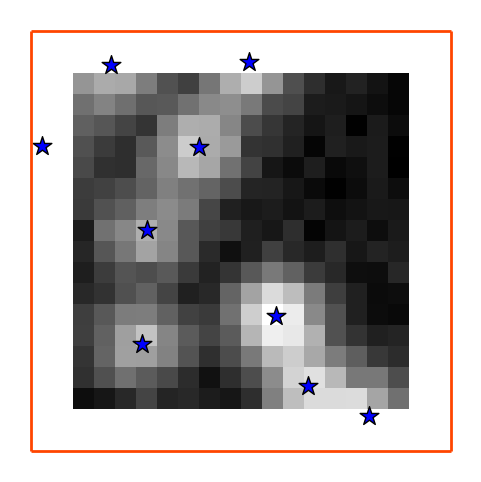

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (6,6))
img = ax.imshow(image.cpu(), cmap = cmap)
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

_ = ax.scatter(locs.cpu()[:counts.cpu().item(), 1] - 0.5,
               locs.cpu()[:counts.cpu().item(), 0] - 0.5,
               color = 'blue', edgecolors = 'black', marker = '*', s = 200)

_ = ax.vlines(x = [outer_min - pad, outer_max + pad],
              ymin = outer_min - pad, ymax = outer_max + pad,
              color = pad_color1, linewidth = linewidth)
_ = ax.hlines(y = [outer_min - pad, outer_max + pad],
              xmin = outer_min - pad, xmax = outer_max + pad,
              color = pad_color1, linewidth = linewidth)

In [11]:
torch.manual_seed(0)

agg = Aggregate(sampler.Prior,
                sampler.ImageModel,
                sampler.tiled_image,
                sampler.counts,
                sampler.locs,
                sampler.features,
                sampler.weights_intercount)

agg.run()

In [12]:
unique, num = agg.features.squeeze().unique(dim = 0, return_counts = True)
catalog_index = (agg.features.squeeze() == unique[num.argmax()]).all(dim = 1).nonzero()[0].item()
locs = agg.locs.squeeze()[catalog_index]
counts = agg.counts.squeeze()[catalog_index]

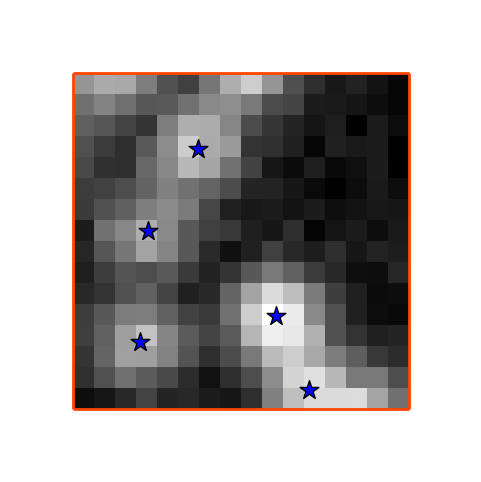

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (6,6))
img = ax.imshow(image.cpu(), cmap = cmap)
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

_ = ax.scatter(locs.cpu()[:counts.cpu().item(), 1] - 0.5,
               locs.cpu()[:counts.cpu().item(), 0] - 0.5,
               color = 'blue', edgecolors = 'black', marker = '*', s = 200)

_ = ax.vlines(x = [outer_min - pad, outer_max + pad],
              ymin = outer_min - pad, ymax = outer_max + pad,
              color = 'white', linewidth = linewidth)
_ = ax.hlines(y = [outer_min - pad, outer_max + pad],
              xmin = outer_min - pad, xmax = outer_max + pad,
              color = 'white', linewidth = linewidth)
_ = ax.vlines(x = [outer_min, outer_max],
              ymin = outer_min, ymax = outer_max,
              color = pad_color1, linewidth = linewidth)
_ = ax.hlines(y = [outer_min, outer_max],
              xmin = outer_min, xmax = outer_max,
              color = pad_color1, linewidth = linewidth)